In [0]:
# Importing the required libraries

import re
import json
import nltk
import tweepy
import pandas as pd
from matplotlib import pyplot as plt

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm

In [3]:
# Setting some golbal varaibles

consumer_key = "########################"
consumer_secret_key ="##########################################"
access_token = "######################################################"
access_token_secret = "###############################################"

auth = tweepy.OAuthHandler(consumer_key,consumer_secret_key)
auth.set_access_token(access_token,access_token_secret)

api = tweepy.API(auth,wait_on_rate_limit=True)
nltk.download('stopwords')
modified_words = stopwords.words('english')
modified_words.remove('not')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# Function to scrap 100 tweets using a particular keyword

def createTestData(word):
    tweets = api.search(q=word,count=100,lang="en",tweet_mode="extended")
    full_tweets = []
    for tweet in tweets:
        if(str(tweet._json["full_text"]).startswith("RT ")):
            full_tweets.append(tweet._json["retweeted_status"]["full_text"])
        else:
            full_tweets.append(tweet._json["full_text"])
    return full_tweets

In [0]:
# Function to clean the tweets

def clean(tweets):
    
    clean_tweets = []
    for temp_tweet in tweets:
        temp_tweet = re.sub(r'http\S+',"",temp_tweet)
        temp_tweet = re.sub(r'[^a-zA-Z]'," ",temp_tweet).lower().split()
        ps = PorterStemmer()
        temp_tweet = [ps.stem(word) for word in temp_tweet if word not in set(stopwords.words('english'))]
        temp_tweet = " ".join(temp_tweet)
        clean_tweets.append(temp_tweet)
    return clean_tweets

In [0]:
# To predict accuracy in case of feedforward neural network

def accuracy(predictions,y):
  correctList = list(torch.round(predictions) == y)
  count = correctList.count(True)
  acc = (100 * count) / len(correctList)
  return acc

In [0]:
#This function essentially prepares the dataset, cleans it, perfroms CountVectorizer on it and return the training and test data

def prepareData(df):
  df = df[["Sentiment","SentimentText"]]
  dataset = list(df.iloc[:,-1].values)
  y = df.iloc[:,0].values
  clean_dataset = clean(dataset)
  cv = CountVectorizer(max_features=5000)
  X = cv.fit_transform(clean_dataset).toarray()
  Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.15)
  return Xtrain, Xtest, ytrain, ytest, cv

In [0]:
# Training Naive Bayes Classifier for text classification

def NaiveBayesClassifier(Xtrain,ytrain,Xtest,ytest):
  nb = GaussianNB()
  nb.fit(Xtrain,ytrain)
  trainPredNB = nb.predict(Xtrain)
  trainAcc= nb.score(Xtrain,ytrain)
  testPredNB = nb.predict(Xtest)
  testAcc = nb.score(Xtest,ytest)
  print("Training Accuracy on Naive Bayes is",trainAcc)
  print("Test Accuracy on Naive Bayes is",testAcc)
  return trainAcc, testAcc,nb

In [0]:
# Training Decision Tree Classifier for text classification

def DecisionTree(Xtrain,ytrain,Xtest,ytest):
  classifier = DecisionTreeClassifier(max_depth=50)
  classifier.fit(Xtrain,ytrain)
  decisionTreeTrainPredictions = classifier.predict(Xtrain)
  decisionTreeTestPredictions = classifier.predict(Xtest)
  trainAcc = accuracy_score(ytrain,decisionTreeTrainPredictions)
  testAcc = accuracy_score(ytest,decisionTreeTestPredictions)

  print("Training Accuracy on Decision Tree is",trainAcc)
  print("Test Accuracy on Decision Tree is",testAcc)

  return trainAcc, testAcc, classifier

In [0]:
# Training Random Forest Classifier for text classification

def RandomForest(Xtrain,Xtest,ytrain,ytest):
  forest = RandomForestClassifier(n_estimators=20)
  forest.fit(Xtrain,ytrain)
  predTrainForest = forest.predict(Xtrain)
  predTestForest = forest.predict(Xtest)
  trainAcc = accuracy_score(ytrain,predTrainForest)
  testAcc = accuracy_score(ytest,predTestForest)

  print("Training Accuracy on Random Forest Classification is",trainAcc)
  print("Test Accuracy on random Forest Classifications is",testAcc)

  return trainAcc, testAcc, forest

In [0]:
class Sentiment(nn.Module):
    def __init__(self,input_features):
        super(Sentiment,self).__init__()
        
        self.layer1 = nn.Linear(in_features=input_features,out_features=500,bias=True)
        self.layer2 = nn.Linear(in_features=500,out_features=120,bias=True)
        self.layer3 = nn.Linear(in_features=120,out_features=84,bias=True)
        self.output = nn.Linear(in_features=84,out_features=1,bias=True)
    
    def forward(self,k):
        k = F.relu(self.layer1(k))
        k = F.relu(self.layer2(k))
        k = F.relu(self.layer3(k))
        k = torch.sigmoid(self.output(k))
        
        return k

In [0]:
# Training Simple Neural Network for text classification
def NeuralNet(Xtrain, Xtest, ytrain, ytest):
  Xtrain = torch.tensor(Xtrain)
  ytrain = torch.tensor(ytrain)
  Xtest = torch.tensor(Xtest)
  ytest = torch.tensor(ytest)

  ytrain = ytrain.reshape(-1,1)
  ytest = ytest.reshape(-1,1)

  Xtrain = Xtrain.cuda()
  ytrain = ytrain.cuda()
  Xtest = Xtest.cuda()
  ytest = ytest.cuda()

  net = Sentiment(Xtrain.shape[1])
  net.cuda()
  losses = []
  optimser = optim.Adam(net.parameters(),lr=0.01)
  criterion = nn.MSELoss()
  for i in tqdm(range(1000)):
      preds = net(Xtrain.float())
      optimser.zero_grad()
      loss = criterion(preds,ytrain.float())
      loss.backward()
      losses.append(loss.item())
      optimser.step()

  predsTrainNN = net(Xtrain.float())
  trainAcc = accuracy(predsTrainNN,ytrain)
  predsTestNN = net(Xtest.float())
  testAcc = accuracy(predsTestNN,ytest)

  print("Training Accuracy on Neural Network is",trainAcc)
  print("Test Accuracy on Neural Network is",testAcc)
  return trainAcc, testAcc, losses, net

In [13]:
df = pd.read_csv("train.csv",encoding="latin-1")
df.head()

,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL frie...
1,2,0,I missed the New Moon trail...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,i think mi bf is cheating on me!!! ...


In [0]:
Xtrain, Xtest, ytrain, ytest, cv = prepareData(df)

In [0]:
originalXtrain = Xtrain
originalXtest = Xtest
originalytrain = ytrain
originalytest = ytest

In [18]:
trainAccNN, testAccNN, losses, net = NeuralNet(Xtrain,Xtest,ytrain,ytest)

100%|██████████| 1000/1000 [07:51<00:00,  2.12it/s]


Training Accuracy on Neural Network is 97.80797740910695
Test Accuracy on Neural Network is 71.08473898259884


In [21]:
trainAccNB, testAccNB, nb = NaiveBayesClassifier(Xtrain,ytrain,Xtest,ytest)

Training Accuracy on Naive Bayes is 0.6644899399929404
Test Accuracy on Naive Bayes is 0.6279751983465565


In [22]:
trainAccDec, testAccDec, classifierDec = DecisionTree(Xtrain,ytrain,Xtest,ytest)

Training Accuracy on Decision Tree is 0.744358159783504
Test Accuracy on Decision Tree is 0.6751783452230149


In [23]:
trainAccForest, testAccForest, forest = RandomForest(Xtrain,Xtest,ytrain,ytest)

Training Accuracy on Random Forest Classification is 0.9800211789622308
Test Accuracy on random Forest Classifications is 0.7133808920594706


**As we compare the accuracies from various algorithm we can conclude that Random Forest Classification algorithm performs the best as compared to Simple Feedforward Neural Network, Naive Bayes and Decision Tree Classification algorithm**

Now lets scarp some tweets from twitter using a particular keyword and then perform sentimnt analysis on it using our Random Forest Classifier

In [0]:
def performSentimentAnalysis(keyword):
  newTestData = createTestData(keyword)
  cleanTestData = clean(newTestData)
  Xclean = cv.transform(cleanTestData).toarray()
  prediction = list(forest.predict(Xclean))
  positive = prediction.count(1)
  negative = prediction.count(0)
  X = [positive,negative]
  labels = ["positive","negative"]
  colors = ["green","red"]
  plt.pie(X,labels=labels,colors=colors,shadow=True,startangle=0,autopct="%1.1f%%")
  plt.title("Sentiment analysis for tweets having keyword "+keyword.upper())
  plt.show()

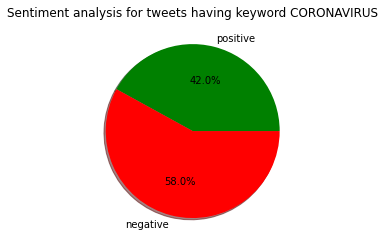

In [100]:
performSentimentAnalysis("coronavirus")